


**Security and Privacy in Machine Learning**


**HW3**


In [43]:
import torch
import gc


def torch_gpu_memory_stats():
    gigabyte = 1024**3

    allocated = torch.cuda.memory_allocated()/(gigabyte)
    reserved = torch.cuda.memory_reserved()/(gigabyte)
    print(f"gpu allocated: {allocated}\ngpu reserved: {reserved}")


def torch_gpu_empty_cache():
    gc.collect()
    torch.cuda.empty_cache()


def torch_gpu_remove_all():
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                if obj.is_cuda:
                    del obj
        except:
            #: There are errors when trying to determine if these objects are tensors or not.
            pass

    torch_gpu_empty_cache()

def torch_memory_tensor(tensor):
    size_in_bytes = tensor.element_size() * tensor.nelement()
    size_in_gigabytes = size_in_bytes / (1024 ** 3)
    return size_in_gigabytes

In [44]:

torch_gpu_remove_all()
torch_gpu_memory_stats()

/home/user01/miniconda3/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


gpu allocated: 10.142563343048096
gpu reserved: 10.666015625


In [45]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  10385 MiB |  10385 MiB | 442493 MiB | 432107 MiB |
|       from large pool |  10376 MiB |  10376 MiB | 442429 MiB | 432053 MiB |
|       from small pool |      9 MiB |     11 MiB |     64 MiB |     54 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  10385 MiB |  10385 MiB | 442493 MiB | 432107 MiB |
|       from large pool |  10376 MiB |  10376 MiB | 442429 MiB |

# **Preface (MUST READ :))**
In this notebook you will firstly train a simple CNN and apply the FGSM attack on it to craft adversarial examples, then you wil launch adversaial training on the same CNN architecture, using your method for crafting adversarial examples. Afterwards you will evaluate the  robustness of the defended CNN against PGD attack and then compare the results of this attack on the defended CNN in different settings.

P.S.1 Reminder that the so-called task might be a little bit time consuming even on CUDA! So make sure to start as soon as you can to meet the excercise deadline properly.

P.S.2 It's suggested to save checkpoints for at least every 10 epochs using Colab GPUs.

P.S.3 Don't forget to add the resnet.py file to the same directory of the current notebook on your PC or on Google Drive (if you want to use the drive)

P.S.4 IMPORTANT: In the answers file you will provide at the end for the questions section, you must present a report including the plots and the required values you are asked for, such as the different accuracy values, the success rates and etc for sections 8, 9, 10, 11, 13, 14, 15, 16. the code of these sections is not enough cause the final report will be checked for the values and plots.

P.S.5 BTW Happy New Year :)

# **Training a ResNet18 model with CIFAR10 Dataset**
Use the cells below to  bulid and train a ResNet18 model on CIFAR10 dataset.

# [1] Initial Setups

In [1]:
# rsp-safe resnet.py user01@x:/home/user01/code/uni/spml/E3
##
%cd ~/code/uni/spml/E3
!mkdir -p ./myCIFAR10

/home/user01/code/uni/spml/E3


In [2]:
! pwd
! ls

/home/user01/code/uni/spml/E3
checkpoint  __pycache__			 resnet18_cifar10_accu85.pth
myCIFAR10   resnet18_cifar10_accu82.pth  resnet.py


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Type
import numpy as np
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from torch.autograd import Variable

from icecream import ic, colorize as ic_colorize
ic.configureOutput(outputFunction=lambda s: print(ic_colorize(s)))

import os
import sys

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
  print(torch.cuda.get_device_name(0))

from resnet import *

cuda
NVIDIA GeForce GTX 1080 Ti


In [44]:
from pynight.common_torch import img_tensor_show, TorchModelMode
from pynight.common_torch import torch_shape_get

# %matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from types import SimpleNamespace

# [2] CIFAR10 Setup

In [187]:
batch_size = 128
batch_size_test = 128 #: 256 made perf worse on 1080 ti, or at least not better

transform_test = transforms.Compose([transforms.ToTensor(),])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [188]:
trainset = torchvision.datasets.CIFAR10(root='./myCIFAR10', train = True, download = True, transform = transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root='./myCIFAR10', train = False, download = True, transform = transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size_test, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [204]:
testloader_b1 = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = False, num_workers = 2)

In [9]:
b1 = next(iter(testloader_b1))
b1[0].max(), b1[0].min()

(tensor(1.), tensor(0.))

In [10]:
torch_shape_get(b1)

[(torch.float32, torch.Size([1, 3, 32, 32])), (torch.int64, torch.Size([1]))]

# [3] Training Setup

In [108]:
from contextlib import nullcontext


In [244]:
def evaluate(model, *, epoch=-1, criterion, best_acc, attack_transform=None, name=None, testloader=testloader):
    dest_dir = f"./{name}"

    with TorchModelMode(model, 'eval'):
        test_loss = 0
        correct = 0
        total = 0
        with (nullcontext() if attack_transform else torch.no_grad()):
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                transformed_inputs = inputs
                if attack_transform:
                    transformed_inputs = attack_transform(inputs, targets)
                
                outputs = model(transform_normalize(transformed_inputs))
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        # Save checkpoint.
        acc = 100.*correct/total
        ic(name, acc, best_acc, correct, total)
        
        if acc > best_acc:
            if name:
                print('Saving..')
                state = {
                    'net': model.state_dict(),
                    'acc': acc,
                    'epoch': epoch,
                }
                if not os.path.isdir(dest_dir):
                    os.mkdir(dest_dir)
                torch.save(state, f'{dest_dir}/ckpt_accu_{acc}.pth')
            
            best_acc = acc

        return best_acc

In [13]:
model = ResNet18()

In [67]:
def model_normalized(model, inputs):
    return model(transform_normalize(inputs))

In [15]:
saved_state = torch.load('./checkpoint/ckpt_accu_94.21.pth', map_location=device)
saved_state['epoch'], saved_state['acc']

(190, 94.21)

In [171]:
model.load_state_dict(saved_state['net'])
model.to(device)
model.eval()

None

In [ ]:
model = model.to(device)
model.train()

In [89]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()

# [4] Train Phase

In [155]:
def train(model, *,
            optimizer,
            criterion,
            scheduler=None,
            attack_transform=None,
            epochs=200,
            best_acc=0,
            best_acc_clean=0,
            name='checkpoint',
            eval_every_n_epochs=10,
            ):
    
    epoch = -1
    def do_eval():
        nonlocal best_acc, best_acc_clean

        if attack_transform:
            best_acc_clean = evaluate(model=model, epoch=epoch, criterion=criterion, best_acc=best_acc_clean, name=f"{name}_clean",)
        
        best_acc = evaluate(model=model, epoch=epoch, criterion=criterion, best_acc=best_acc, name=name, attack_transform=attack_transform)

    do_eval()

    for epoch in range(epochs):
        with TorchModelMode(model, 'train'):
            print("epoch " + str(epoch + 1))
            running_loss = 0.0
            epoch_loss = 0.0

            for i, data in enumerate(trainloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad() #: @redundant
                transformed_inputs = inputs
                if attack_transform:
                    transformed_inputs = attack_transform(inputs, labels)
                
                optimizer.zero_grad()
                outputs = model_normalized(model, transformed_inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # print statistics
                running_loss += loss.item()
                epoch_loss += loss.item()
                if i % 2000 == 1:    # print every 2000 mini-batches #1999
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.12f}')
                    running_loss = 0.0
            
            ic(epoch_loss)
            
            if scheduler:
                # scheduler.step(epoch_loss)
                scheduler.step()

            if (epoch % eval_every_n_epochs == 0) or (epoch == epochs - 1):
                do_eval()

    print('Finished Training')
    return best_acc, best_acc_clean

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                    momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

train(model=model,
      optimizer=optimizer,
      scheduler=scheduler,
      criterion=criterion,
      epochs=200,
      best_acc=0,)

In [ ]:
model

In [79]:
next(model.parameters()).device

device(type='cuda', index=0)

In [22]:
next(model.parameters()).is_cuda

True

# [5] Evaluating Total Standard Accuracy
Check your model accuracy with the following piece of code

In [82]:
with TorchModelMode(model, 'eval'):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_normalized(model, images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Standard Accuracy of ResNet18 model on the 10000 test images: {100 * correct / total} %')

Standard Accuracy of ResNet18 model on the 10000 test images: 93.9 %


In [246]:
evaluate(model=model, criterion=criterion, best_acc=0)

ic| name: None, acc: 94.3, best_acc: 0, correct: 9430, total: 10000


94.3

In [247]:
evaluate(model=model, criterion=criterion, best_acc=0, testloader=trainloader)

ic| name: None, acc: 100.0, best_acc: 0, correct: 50000, total: 50000


100.0

In [249]:
!fd --absolute-path '\.pth$'

/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_59.02.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_85.09.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_85.29.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_85.4.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_85.7.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_86.8.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_86.84.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_87.25.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_90.1.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_90.89.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_90.95.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_91.43.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_92.31.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_92.33.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_93.4.pth
/home/user01/code/uni/spml/E3/checkpoint/ckpt_accu_93.69.pth
/home/user01/code/uni/spml/E3

# [6] Saving the trained model (Optional)

In [83]:
model.eval()
# model_name = "resnet18_cifar10_model_std"
# CIFAR10_model_PATH = "/content/drive/MyDrive/" + model_name
# torch.save(model.state_dict(), CIFAR10_model_PATH)

None

# **Implementing FGSM**

# [7] Fast Gradient Sign Method
You must complete the required sections with proper code for FGSM attack

In [184]:
class FGSMAttack():
    def __init__(self, model):
        self.model = model



    def untargeted_fgsm(self, image, epsilon, gradient, step_size):
      # Define untargeted fast gradient sign attack pertubation
      # Firstly perturb the image in the proper direction then clamp it between the right values.
      #############################
      # Your code goes here
      gradient_sign = gradient.sign()
      perturbed_image = image + step_size * gradient_sign
      perturbed_image = torch.clamp(perturbed_image, image - epsilon, image + epsilon)
      perturbed_image = torch.clamp(perturbed_image, 0, 1)
      return perturbed_image
      #############################


    def attack_pgd(self, *, images, labels, step_size=None, num_steps=1, epsilon, cpu_perturbed_images_p, return_only_perturbed_images_p=True):
      if step_size is None:
        step_size = epsilon

      inputs = images
      for i in range(num_steps):
        if i == 0:
          return_only_perturbed_images_p_curr = return_only_perturbed_images_p
        else:
          return_only_perturbed_images_p_curr = True
        
        if i == (num_steps - 1):
          cpu_perturbed_images_p_curr = cpu_perturbed_images_p
        else:
          cpu_perturbed_images_p_curr = False

        attack_res = self.attack(images=inputs,
                    labels=labels,
                    epsilon=epsilon,
                    step_size=step_size,
                    return_originals_p=(not return_only_perturbed_images_p_curr),
                    return_new_preds=(not return_only_perturbed_images_p_curr),
                    cpu_perturbed_images_p=cpu_perturbed_images_p_curr)
        inputs = attack_res.adversarials
        if i == 0:
          first_res = attack_res

      first_res.adversarials = inputs
      return first_res


    def attack(self, images, labels, epsilon, step_size=None, return_new_preds=True, cpu_perturbed_images_p=True, return_originals_p=True):
      if step_size is None:
        step_size = epsilon
    
      with TorchModelMode(self.model, 'eval'):
        true_images = images.clone().detach()
        images = images.to(device)

        labels = labels.to(device)

        self.model.zero_grad()
        images.grad = None
        images.requires_grad = True

        pred_orig_logits = self.model(transform_normalize(images))
        pred_orig_probs = F.softmax(pred_orig_logits, dim=1)
        # ic(pred_probs.shape, labels.shape)
        pred_orig_probs_max, pred_orig_probs_indices = torch.max(pred_orig_probs, dim=1)

        loss = F.nll_loss(pred_orig_logits, labels)
        loss.backward()
        gradients = images.grad.detach()
        perturbed_images = self.untargeted_fgsm(images, epsilon, gradients, step_size=step_size)

        if cpu_perturbed_images_p:
          perturbed_images_np = perturbed_images.detach().cpu().numpy()
          perturbed_images_ret = [perturbed_images_np[i] for i in range(perturbed_images_np.shape[0])]
        else:
          perturbed_images_ret = perturbed_images.detach()


        originals = None
        predictions_orig = None
        confidences_orig_lst = None
        truths = None
        if return_originals_p:
          originals = [true_images[i].detach().cpu().numpy() for i in range(true_images.shape[0])]

          predictions_orig_np = pred_orig_probs_indices.detach().cpu().numpy()
          predictions_orig = [predictions_orig_np[i] for i in range(len(predictions_orig_np))]

          confidences_orig_np = pred_orig_probs_max.detach().cpu().numpy()
          confidences_orig_lst = [confidences_orig_np[i] for i in range(len(confidences_orig_np))]
          
          truths_np = labels.detach().cpu().numpy()
          truths = [truths_np[i] for i in range(len(truths_np))]

        confidences_adv_lst = None
        predictions_adv = None
        if return_new_preds: #: @expensive
          with torch.no_grad():
            pred_adv_logits = self.model(transform_normalize(perturbed_images))
            pred_adv_probs = F.softmax(pred_adv_logits, dim=1)
            pred_adv_probs_max, pred_adv_probs_indices = torch.max(pred_adv_probs, dim=1)

          predictions_adv_np = pred_adv_probs_indices.detach().cpu().numpy()
          predictions_adv = [predictions_adv_np[i] for i in range(len(predictions_adv_np))]

          confidences_adv_np = pred_adv_probs_max.detach().cpu().numpy()
          confidences_adv_lst = [confidences_adv_np[i] for i in range(len(confidences_adv_np))]

        return SimpleNamespace(adversarials=perturbed_images_ret, originals=originals, predictions_orig=predictions_orig, predictions=predictions_adv, confidences_orig=confidences_orig_lst, confidences=confidences_adv_lst, truths=truths)

In [157]:
class FGSMTransform(nn.Module):
    def __init__(self, model, epsilon,):
        super(FGSMTransform, self).__init__()
        self.fgsm_attack = FGSMAttack(model)
        self.epsilon = epsilon
        self.return_new_preds = False
        self.return_originals_p = False
        self.cpu_perturbed_images_p = False


    def forward(self, inputs, labels):
        attack_res = self.fgsm_attack.attack(inputs, labels, self.epsilon,
                                        return_new_preds=self.return_new_preds,
                                        cpu_perturbed_images_p=self.cpu_perturbed_images_p, return_originals_p=self.return_originals_p)
        transformed_inputs = attack_res.adversarials
        return transformed_inputs

In [159]:
class PGDTransform(nn.Module):
    def __init__(self, model, epsilon, step_size, num_steps):
        super(PGDTransform, self).__init__()
        self.fgsm_attack = FGSMAttack(model)
        self.epsilon = epsilon
        self.step_size = step_size
        self.num_steps = num_steps
        self.return_only_perturbed_images_p = True
        self.cpu_perturbed_images_p = False


    def forward(self, inputs, labels):
        attack_res = self.fgsm_attack.attack_pgd(
            images=inputs,
            labels=labels,
            epsilon=self.epsilon,
            cpu_perturbed_images_p=self.cpu_perturbed_images_p,
            step_size=self.step_size,
            num_steps=self.num_steps,
            return_only_perturbed_images_p=self.return_only_perturbed_images_p)
        transformed_inputs = attack_res.adversarials
        return transformed_inputs

# [8] Evaluating FGSM Accuracy of Standard Trained Model

In [194]:
# For 3 values of epsilon = 4/255, 8/255, 12/255
# Launch the FGSM attack,
# Use the whole testloader to generate a set of adversarial examples on the CIFAR10 testset
# Then use this new testset for calculating the adversarial accuracy of the standard target model
#############################
# Your code goes here
epsilons = [4/255, 8/255, 12/255]
fgsm_attack = FGSMAttack(model)
epsilon_fgsm = dict()
for epsilon in epsilons:
  adversarials = []
  originals = []
  predictions_adv = []
  confidences = []
  truths = []
  epsilon_fgsm[epsilon] = dict(adversarials=adversarials, originals=originals, predictions=predictions_adv, confidences=confidences, truths=truths)

for data in (testloader):
  inputs, labels = data[0], data[1]
  # ic(inputs.shape)
  
  for epsilon in epsilons:
    attack_res = fgsm_attack.attack(inputs, labels, epsilon)
    adv = attack_res.adversarials
    orig = attack_res.originals
    pred = attack_res.predictions
    conf = attack_res.confidences
    truth = attack_res.truths

    epsilon_fgsm[epsilon]['adversarials'].extend(adv)
    epsilon_fgsm[epsilon]['originals'].extend(orig)
    epsilon_fgsm[epsilon]['predictions'].extend(pred)
    epsilon_fgsm[epsilon]['confidences'].extend(conf)
    epsilon_fgsm[epsilon]['truths'].extend(truth)
#############################

# [9] Crafting Adversarial Examples with FGSM

In [195]:
# Using the epsilon value of 8/255
# For the first 5 adversarial images, 
# Print the true label, the model prediction and the confidence of each prediction for each image
#############################
# Your code goes here
epsilon = 8/255
adv = epsilon_fgsm[epsilon]['adversarials']
orig = epsilon_fgsm[epsilon]['originals']
pred = epsilon_fgsm[epsilon]['predictions']
conf = epsilon_fgsm[epsilon]['confidences']
truth = epsilon_fgsm[epsilon]['truths']

for i in range(5):
  print(f"True Label: {truth[i]}\nModel Prediction: {pred[i]}\nConfidence: {conf[i]}\n")
#############################

True Label: 3
Model Prediction: 5
Confidence: 0.8451736569404602

True Label: 8
Model Prediction: 1
Confidence: 0.9035457968711853

True Label: 8
Model Prediction: 1
Confidence: 0.855281412601471

True Label: 0
Model Prediction: 8
Confidence: 0.9863501191139221

True Label: 6
Model Prediction: 2
Confidence: 0.6483242511749268



In [196]:
import collections

freq_table = collections.Counter(pred)

print("Frequency table:")
for number, frequency in freq_table.items():
    print(f"{number}: {frequency}")

Frequency table:
5: 691
1: 602
8: 862
2: 1634
3: 1099
6: 1713
9: 1006
7: 538
4: 1333
0: 522


# [10] Plotting


In [179]:
import matplotlib.pyplot as plt

# Now show the 5 original test images mentioned in the previous cell
# And the FGSM perturbation added to each image (with epsilon = 8/255)
# Then the adversarial example created on the same 5 test images using the mentioned FGSM perturbation
#############################
# Your code goes here

def plot_perturb(orig, adv, pred, conf, truth):
  for i in range(5):
    s = 1
    fig, ax = plt.subplots(ncols=7, figsize=(s*8, s*1))

    plt.rcParams.update({'font.size': 6})

    ax[0].imshow(orig[i].transpose(1,2,0))
    ax[0].set_title(f"Truth={classes[truth[i]]}")
    ax[0].axis('off')

    ax[1].imshow(adv[i].transpose(1,2,0))
    ax[1].set_title(f"p({classes[pred[i]]})={conf[i]:.2f}")
    ax[1].axis('off')

    ax[2].imshow(np.clip((adv[i] - orig[i]).transpose(1,2,0), 0, 1))
    ax[2].set_title(f"raw perturb")
    ax[2].axis('off')

    normalized_perturb = np.clip(((adv[i] - orig[i]) + 0.5).transpose(1,2,0), 0.0, 1.0)
    ax[3].imshow(normalized_perturb)
    ax[3].set_title(f"normalized perturb")
    ax[3].axis('off')

    perturb_scale = 10
    scaled_normalized_perturb = np.where(normalized_perturb > 0.5, normalized_perturb*perturb_scale, normalized_perturb/perturb_scale)
    ax[4].imshow(np.clip(scaled_normalized_perturb, 0.0, 1.0))
    ax[4].set_title(f"scaled perturb")
    ax[4].axis('off')

    perturb_scale = 50
    ax[5].imshow(np.clip(perturb_scale*((adv[i] - orig[i])).transpose(1,2,0), 0.0, 1.0))
    ax[5].set_title(f"scaled raw")
    ax[5].axis('off')

    ax[6].imshow(np.clip(-1*perturb_scale*((adv[i] - orig[i])).transpose(1,2,0), 0.0, 1.0))
    ax[6].set_title(f"scaled -raw")
    ax[6].axis('off')

    plt.show()
  #############################

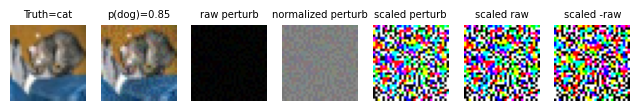

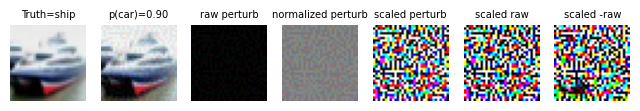

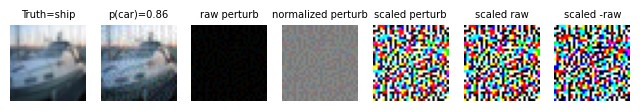

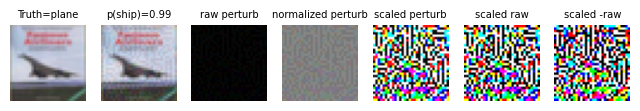

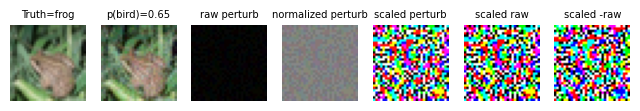

In [197]:
adv = epsilon_fgsm[epsilon]['adversarials']
orig = epsilon_fgsm[epsilon]['originals']
pred = epsilon_fgsm[epsilon]['predictions']
conf = epsilon_fgsm[epsilon]['confidences']
truth = epsilon_fgsm[epsilon]['truths']

plot_perturb(orig, adv, pred, conf, truth)

# [11] **Adversarial Training**

In [138]:
model_fgsm = ResNet18()

In [139]:
# Now train a ResNet model with FGSM adversarial examples crafted on CIFAR10 trainset
# Then report the clean accuracy of this adversarially trained network on the clean CIFAR10 testset
# Also report the adversarial accuracy of this adversarially trained network against FGSM with epsilon = 8/255 on the CIFAR10 testset
# Try using a scheduler for the learning rate (if needed)
#############################
# Your code goes here
epochs_fgsm = 120
fgsm_epsilon=(8/255)
fgsm_transform = FGSMTransform(model=model, epsilon=epsilon,)
        
optimizer_fgsm = optim.SGD(model_fgsm.parameters(), lr=learning_rate,
                    momentum=0.9, weight_decay=5e-4)
scheduler_fgsm = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_fgsm, T_max=epochs_fgsm)

model_fgsm = model_fgsm.to(device)

model_fgsm.train()

train(model=model_fgsm,
      optimizer=optimizer_fgsm,
      scheduler=scheduler_fgsm,
      criterion=criterion,
      epochs=epochs_fgsm,
      best_acc=0,
      best_acc_clean=0,
      attack_transform=fgsm_transform,
      name='cifar10_fgsm_8_255',
      eval_every_n_epochs=5,)

model_fgsm.eval()

None
#############################

ic| name: 'cifar10_fgsm_8_255_clean'
    acc: 10.0
    best_acc: 0
    correct: 1000
    total: 10000
Saving..
ic| name: 'cifar10_fgsm_8_255'
    acc: 9.78
    best_acc: 0
    correct: 978
    total: 10000
Saving..
epoch 1
[1,     2] loss: 0.002396087646
ic| epoch_loss: 800.5772511959076
ic| name: 'cifar10_fgsm_8_255_clean'
    acc: 37.71
    best_acc: 10.0
    correct: 3771
    total: 10000
Saving..
ic| name: 'cifar10_fgsm_8_255'
    acc: 27.57
    best_acc: 9.78
    correct: 2757
    total: 10000
Saving..
epoch 2
[2,     2] loss: 0.002001185298
ic| epoch_loss: 738.5678005218506
epoch 3
[3,     2] loss: 0.001788885176
ic| epoch_loss: 702.6272187232971
epoch 4
[4,     2] loss: 0.001779402912
ic| epoch_loss: 677.6243134737015
epoch 5
[5,     2] loss: 0.001709280968
ic| epoch_loss: 649.1414989233017
epoch 6
[6,     2] loss: 0.001608158052
ic| epoch_loss: 629.9283205270767
ic| name: 'cifar10_fgsm_8_255_clean'
    acc: 60.93
    best_acc: 37.71
    correct: 6093
    total: 10000
Saving..
i

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [251]:
evaluate(model=model_fgsm, criterion=criterion, attack_transform=None, best_acc=0, testloader=trainloader)

ic| name: None, acc: 91.66, best_acc: 0, correct: 45830, total: 50000


91.66

In [250]:
evaluate(model=model_fgsm, criterion=criterion, attack_transform=None, best_acc=0)

ic| name: None, acc: 82.21, best_acc: 0, correct: 8221, total: 10000


82.21

In [160]:
evaluate(model=model_fgsm, criterion=criterion, attack_transform=FGSMTransform(model=model_fgsm, epsilon=1/255,), best_acc=0)

ic| name: None, acc: 46.01, best_acc: 0, correct: 4601, total: 10000


46.01

In [161]:
evaluate(model=model_fgsm, criterion=criterion, attack_transform=FGSMTransform(model=model_fgsm, epsilon=2/255,), best_acc=0)

ic| name: None, acc: 38.58, best_acc: 0, correct: 3858, total: 10000


38.58

In [162]:
evaluate(model=model_fgsm, criterion=criterion, attack_transform=FGSMTransform(model=model_fgsm, epsilon=3/255,), best_acc=0)

ic| name: None, acc: 46.09, best_acc: 0, correct: 4609, total: 10000


46.09

In [163]:
evaluate(model=model_fgsm, criterion=criterion, attack_transform=FGSMTransform(model=model_fgsm, epsilon=4/255,), best_acc=0)

ic| name: None, acc: 65.32, best_acc: 0, correct: 6532, total: 10000


65.32

In [141]:
evaluate(model=model_fgsm, criterion=criterion, attack_transform=FGSMTransform(model=model_fgsm, epsilon=8/255,), best_acc=0)

ic| name: None, acc: 97.71, best_acc: 0, correct: 9771, total: 10000


97.71

# **Implementing PGD**

# [12] Projected Gradient Descent
You must complete the required sections with proper code for PGD attack

In [ ]:
#: Use PGDTransform defined above

# [13] Evaluating PGD Accuracy of Adversarially Trained Model and Standard Trained Model

In [174]:
# Now launch the attack with the proper inputs for the whole CIFAR10 testset (with epsilon = 8/255)
# on the adversarially trained model and the standard trained model with 2 different step settings: k = 2 and k = 4
# Then print the PGD Accuracy for the images crafted with these 2 settings on the defended model and the standard model

# By PGD Accuracy we mean check if the adversarially trained model could still understand the true label that must be predicted
# Or will the model still get fooled by the PGD attack again after the FGSM adversarial training?
#############################
# Your code goes here
ic(evaluate(model=model, criterion=criterion, attack_transform=PGDTransform(model=model, epsilon=8/255, step_size=4/255, num_steps=2), best_acc=0))
ic(evaluate(model=model_fgsm, criterion=criterion, attack_transform=PGDTransform(model=model_fgsm, epsilon=8/255, step_size=4/255, num_steps=2), best_acc=0))

ic(evaluate(model=model, criterion=criterion, attack_transform=PGDTransform(model=model, epsilon=8/255, step_size=2/255, num_steps=4), best_acc=0))
ic(evaluate(model=model_fgsm, criterion=criterion, attack_transform=PGDTransform(model=model_fgsm, epsilon=8/255, step_size=2/255, num_steps=4), best_acc=0))

None
############################# 

ic| name: None, acc: 16.28, best_acc: 0, correct: 1628, total: 10000
ic| evaluate(model=model, criterion=criterion, attack_transform=PGDTransform(model=model, epsilon=8/255, step_size=4/255, num_steps=2), best_acc=0): 16.28
ic| name: None, acc: 32.11, best_acc: 0, correct: 3211, total: 10000
ic| evaluate(model=model_fgsm, criterion=criterion, attack_transform=PGDTransform(model=model_fgsm, epsilon=8/255, step_size=4/255, num_steps=2), best_acc=0): 32.11
ic| name: None, acc: 6.23, best_acc: 0, correct: 623, total: 10000
ic| evaluate(model=model, criterion=criterion, attack_transform=PGDTransform(model=model, epsilon=8/255, step_size=2/255, num_steps=4), best_acc=0): 6.23
ic| name: None, acc: 5.52, best_acc: 0, correct: 552, total: 10000
ic| evaluate(model=model_fgsm, criterion=criterion, attack_transform=PGDTransform(model=model_fgsm, epsilon=8/255, step_size=2/255, num_steps=4), best_acc=0): 5.52


In [248]:
for epsilon in [4/255, 8/255, 12/255]:
	clean_model_fgsm_accu = (evaluate(model=model, criterion=criterion, attack_transform=FGSMTransform(model=model, epsilon=epsilon), best_acc=0))

	fgsm_model_fgsm_accu = (evaluate(model=model_fgsm, criterion=criterion, attack_transform=FGSMTransform(model=model_fgsm, epsilon=epsilon), best_acc=0))

	print(f"""model=clean, epsilon={epsilon}, accuracy={clean_model_fgsm_accu}""")
	print(f"""model=fgsm, epsilon={epsilon}, accuracy={fgsm_model_fgsm_accu}""")

ic| name: None, acc: 43.33, best_acc: 0, correct: 4333, total: 10000
ic| name: None, acc: 65.16, best_acc: 0, correct: 6516, total: 10000
model=clean, epsilon=0.01568627450980392, accuracy=43.33
model=fgsm, epsilon=0.01568627450980392, accuracy=65.16
ic| name: None, acc: 35.27, best_acc: 0, correct: 3527, total: 10000
ic| name: None, acc: 98.02, best_acc: 0, correct: 9802, total: 10000
model=clean, epsilon=0.03137254901960784, accuracy=35.27
model=fgsm, epsilon=0.03137254901960784, accuracy=98.02
ic| name: None, acc: 29.07, best_acc: 0, correct: 2907, total: 10000
ic| name: None, acc: 76.18, best_acc: 0, correct: 7618, total: 10000
model=clean, epsilon=0.047058823529411764, accuracy=29.07
model=fgsm, epsilon=0.047058823529411764, accuracy=76.18


# [14] Plotting

In [192]:
epsilons = [8/255,]
fgsm_attack = FGSMAttack(model)
epsilon_pgd = dict()
for epsilon in epsilons:
  adversarials = []
  originals = []
  predictions_adv = []
  confidences = []
  truths = []
  epsilon_pgd[epsilon] = dict(adversarials=adversarials, originals=originals, predictions=predictions_adv, confidences=confidences, truths=truths)

i = 0
for data in (testloader):
  i += 1
  if i >= 6:
    break

  inputs, labels = data[0], data[1]
  # ic(inputs.shape)
  
  for epsilon in epsilons:
    attack_res = fgsm_attack.attack_pgd(images=inputs, labels=labels, epsilon=epsilon, num_steps=4, step_size=2/255, return_only_perturbed_images_p=False, cpu_perturbed_images_p=True)
    adv = attack_res.adversarials
    orig = attack_res.originals
    pred = attack_res.predictions
    conf = attack_res.confidences
    truth = attack_res.truths

    epsilon_pgd[epsilon]['adversarials'].extend(adv)
    epsilon_pgd[epsilon]['originals'].extend(orig)
    epsilon_pgd[epsilon]['predictions'].extend(pred)
    epsilon_pgd[epsilon]['confidences'].extend(conf)
    epsilon_pgd[epsilon]['truths'].extend(truth)

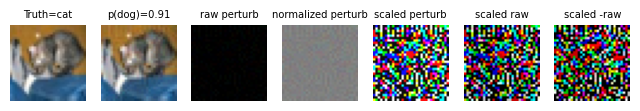

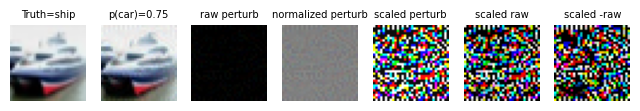

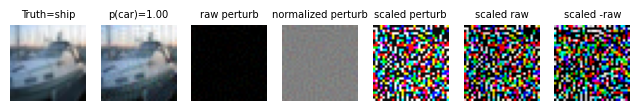

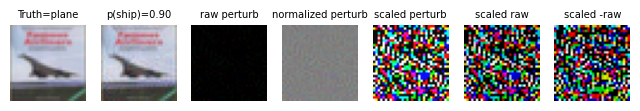

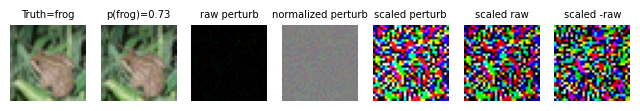

In [193]:
# Now show 5 original test images from the CIFAR10 testset 
# And the PGD perturbation added to each image (with epsilon = 8/255)
# Then the adversarial example created on the same 5 test images using the mentioned PGD perturbation
#############################
# Your code goes here
adv = epsilon_pgd[epsilon]['adversarials']
orig = epsilon_pgd[epsilon]['originals']
pred = epsilon_pgd[epsilon]['predictions']
conf = epsilon_pgd[epsilon]['confidences']
truth = epsilon_pgd[epsilon]['truths']

plot_perturb(orig, adv, pred, conf, truth)
#############################

# [15] Noisy Input Accuracy

In [252]:
# Add Gaussian noise with mean of 0 and variance of 6/255 to the CIFAR10 testset
# Evaluate the accuracy of these noisy images on the standard trained model and the adversarially trained model
# What do you conclude from the results of applying noisy inputs and adversarial example inputs to both of the models?
#############################
# Your code goes here
def transform_noise(inputs, labels):
  noise = torch.randn_like(inputs) * np.sqrt(6/255)
  noisy_inputs = inputs + noise
  noisy_inputs = torch.clamp(noisy_inputs, 0, 1)
  return noisy_inputs


ic(evaluate(model=model, criterion=criterion, attack_transform=transform_noise, best_acc=0))
ic(evaluate(model=model_fgsm, criterion=criterion, attack_transform=transform_noise, best_acc=0))
#############################

ic| name: None, acc: 15.1, best_acc: 0, correct: 1510, total: 10000
ic| evaluate(model=model, criterion=criterion, attack_transform=transform_noise, best_acc=0): 15.1
ic| name: None, acc: 41.37, best_acc: 0, correct: 4137, total: 10000
ic| evaluate(model=model_fgsm, criterion=criterion, attack_transform=transform_noise, best_acc=0): 41.37


41.37

# [16] Logit VS Epsilon Test

In [ ]:
# Pick the first image x from the CIFAR10 testset
# Make sure the prediction for this image is done correctly by the standard trained model
# Compute the gradient of the model's loss with respect to the image x
# Now for the epsilon values between -0.5 and 0.5 with step size of 0.01 (101 different values),
# Compute x + \epsilon.sign(\nabla_x J(W, x, y))
# Get the logit value for these 101 different images (by logit we mean the softmax input)
# Then plot the logit value vs the epsilon value diagram
# Now choose a random direction instead of \nabla_x J(W, x, y), from the Uniform basis between -1 and 1 for each dimension
# Plot the logit value vs the epsilon value diagram with respect to the new direction
# What is your conclusion based on the results achieved from the two digrams?
#############################

In [215]:
testloader_b1_iter = iter(testloader_b1)
next(testloader_b1_iter)
None

/tmp/ipykernel_810908/1572740967.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


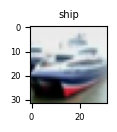

In [216]:
import torch

correct_prediction = False

while not correct_prediction:
    image, label = next(testloader_b1_iter)
    label = torch.tensor(label, dtype=torch.long)

    output = model(image.to(device))
    predicted = torch.argmax(output, dim=1).item()

    if predicted == label:
        correct_prediction = True
    else:
        print("Prediction is incorrect. Retrying ...")
        
label_txt = (classes[label.item()])

fig, ax = plt.subplots(figsize=(1, 1))
ax.set_title(label_txt)
ax.imshow(image.squeeze().permute(1, 2, 0),)

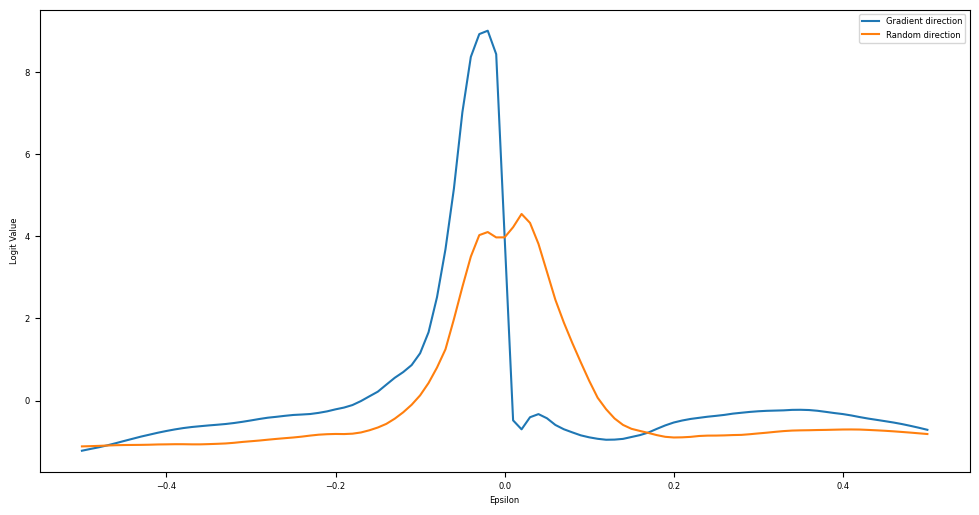

: 

In [254]:
with TorchModelMode(model, 'eval'):
	image = image.to(device)
	label = label.to(device)
	image.requires_grad = True

	output = model(image)
	loss = F.nll_loss(output, label)
	model.zero_grad()
	loss.backward()
	grad = image.grad.detach()

	epsilons = np.arange(-0.5, 0.51, 0.01)
	epsilons = np.append(epsilons, 0.0)
	epsilons.sort()

	logit_values_gradient = []
	logit_values_random = []

	random_direction = torch.FloatTensor(grad.shape).uniform_(-1, 1).to(device)
	
	for epsilon in epsilons:

		perturbed_image_gradient = image + epsilon * grad.sign()
		
		perturbed_image_random = image + epsilon * random_direction.sign()
		
		with torch.no_grad():
			logit_gradient = model(perturbed_image_gradient)[0, label]
			logit_random = model(perturbed_image_random)[0, label]
		
		logit_values_gradient.append(logit_gradient.item())
		logit_values_random.append(logit_random.item())

	plt.figure(figsize=(12, 6))
	plt.plot(epsilons, logit_values_gradient, label='Gradient direction')
	plt.plot(epsilons, logit_values_random, label='Random direction')
	plt.xlabel('Epsilon')
	plt.ylabel('Logit Value')
	plt.legend()
	plt.show()

In [237]:
epsilons[50], logit_values_random[50], logit_values_gradient[50]

(0.0, 3.974334478378296, 3.974334478378296)

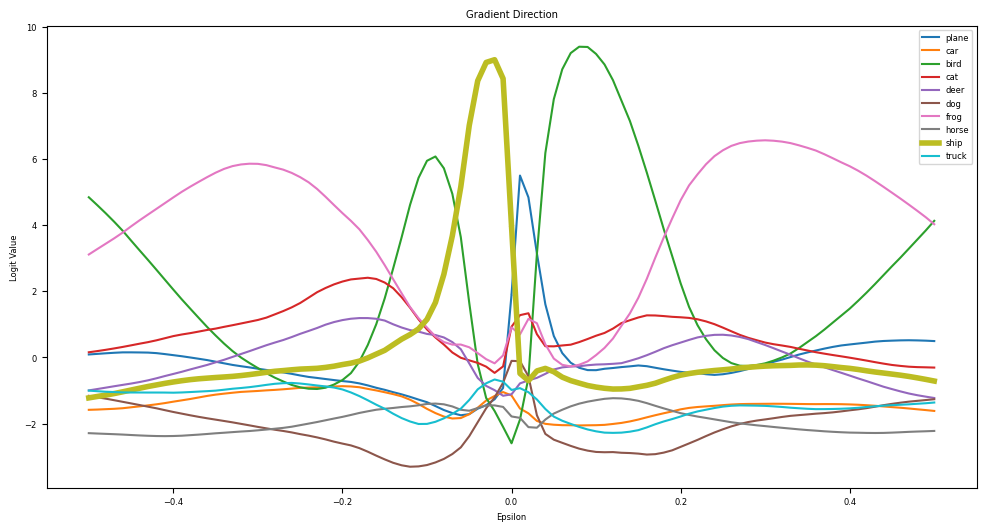

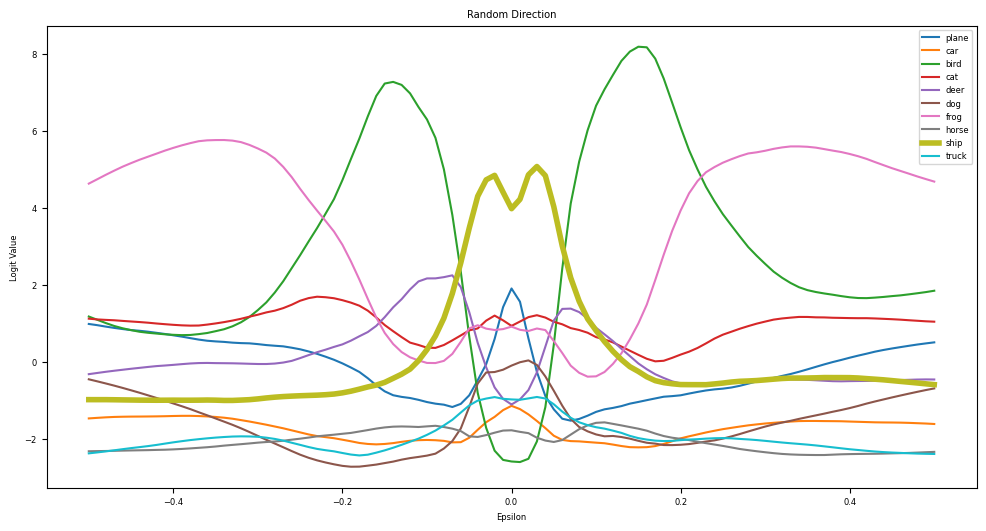

In [253]:

logit_values_gradient = {class_name: [] for class_name in classes}
logit_values_random = {class_name: [] for class_name in classes}

random_direction = torch.FloatTensor(grad.shape).uniform_(-1, 1).to(device)

for epsilon in epsilons:
    perturbed_image_gradient = image + epsilon * grad.sign()
    
    perturbed_image_random = image + epsilon * random_direction.sign()
    
    with torch.no_grad():
        logits_gradient = model(perturbed_image_gradient)
        logits_random = model(perturbed_image_random)
    
    for class_index, class_name in enumerate(classes):
        logit_values_gradient[class_name].append(logits_gradient[0, class_index].item())
        logit_values_random[class_name].append(logits_random[0, class_index].item())


plt.figure(figsize=(12, 6))
for class_index, class_name in enumerate(classes):
    if class_index == label:
        plt.plot(epsilons, logit_values_gradient[class_name], label=class_name, linewidth=4)
    else:
        plt.plot(epsilons, logit_values_gradient[class_name], label=class_name)
plt.xlabel('Epsilon')
plt.ylabel('Logit Value')
plt.title('Gradient Direction')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for class_index, class_name in enumerate(classes):
    if class_index == label:
        plt.plot(epsilons, logit_values_random[class_name], label=class_name, linewidth=4)
    else:
        plt.plot(epsilons, logit_values_random[class_name], label=class_name)
plt.xlabel('Epsilon')
plt.ylabel('Logit Value')
plt.title('Random Direction')
plt.legend()
plt.show()

